In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
def generate_data(batch_size, input_dim):
    return torch.randn(batch_size, input_dim)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        # First hidden layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # Second hidden layer
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

def prepare_quantum_state(params):
    num_qubits = 4
    qc = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        qc.rx(params[i], i)
        qc.rz(params[i + num_qubits], i)
    
    return qc


Epoch 1/100, Loss: 1.044258952140808
Epoch 11/100, Loss: 0.8166536092758179
Epoch 21/100, Loss: 0.6157158613204956
Epoch 31/100, Loss: 0.4147632122039795
Epoch 41/100, Loss: 0.2748115062713623
Epoch 51/100, Loss: 0.1872440129518509
Epoch 61/100, Loss: 0.13177159428596497
Epoch 71/100, Loss: 0.0916190892457962
Epoch 81/100, Loss: 0.07822291553020477
Epoch 91/100, Loss: 0.04925726726651192


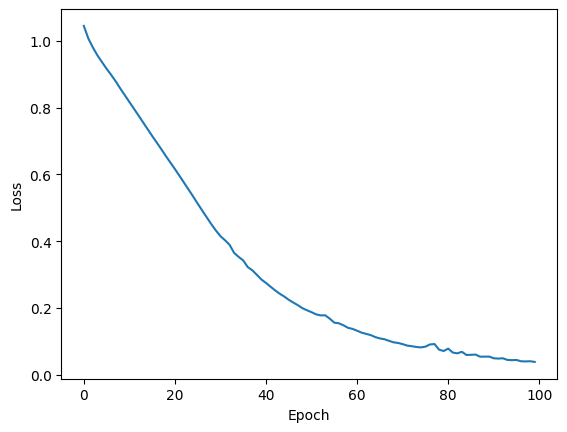

estimated_params= tensor([[-1.8887, -0.8370, -0.3050,  0.2798,  0.1369,  0.5015, -1.3370, -0.1259]],
       grad_fn=<AddmmBackward0>)
Measurement result: {'0011': 107, '1010': 2, '1001': 10, '0001': 545, '0000': 273, '1011': 1, '0010': 50, '0101': 13, '1000': 6, '0100': 10, '0110': 2, '0111': 2, '1101': 3}


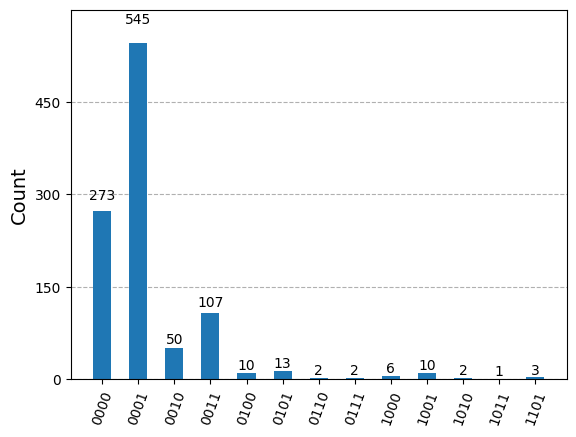

In [3]:
def train_mlp(model, data, target, num_epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

input_dim = 5   
hidden_dim = 64
output_dim = 8  # 4Qubits * 2 parameters (RX, RZ)

mlp = MLP(input_dim, hidden_dim, output_dim)

train_data = generate_data(100, input_dim)
target_params = torch.randn(100, output_dim) 

# Train MLP
train_mlp(mlp, train_data, target_params)


test_data = generate_data(1, input_dim)  
estimated_params = mlp(test_data)
print("estimated_params=", estimated_params)

qc = prepare_quantum_state(estimated_params[0].detach().numpy())

qc.measure_all()


simulator = AerSimulator()  
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()

counts = result.get_counts()
print("Measurement result:", counts)
plot_histogram(counts)


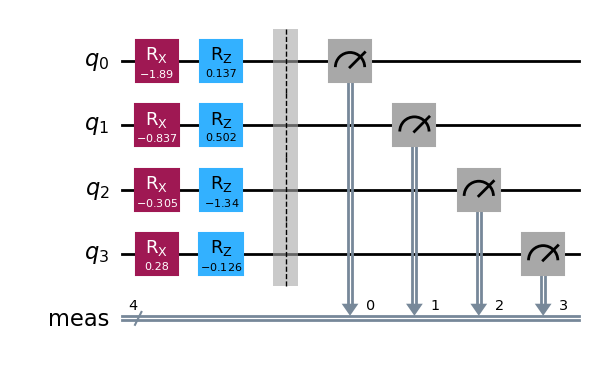

In [4]:
qc.draw('mpl')